In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, ZeroPadding2D
from keras import Input, Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import optimizers, losses, metrics
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
import tensorflow as tf


%matplotlib inline

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### **IMPORT MODEL & PREPROCESSING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
# extract dataset.
!unzip drive/MyDrive/AML-Project/Dataset/fruit-360.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg  
  inflating: fruits-360/Training/Tomato 3/130_100.jpg 

In [ ]:
path = 'fruits-360/'
Test = 'fruits-360/Test'

In [ ]:
!pip install split-folders
import splitfolders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(Test, output=path+"Test_Validation", seed=1337, ratio=(.5, .5,)) # default values

Copying files: 22688 files [00:04, 5329.11 files/s]


In [ ]:
train = 'fruits-360/Training/'
validation = 'fruits-360/Test_Validation/train'
test = 'fruits-360/Test_Validation/val'
multi = 'fruits-360/test-multiple_fruits/'

In [ ]:
H = 100
W = 100
C = "rgb"

train_processing = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                   validation_split=0
                                                                   )

train_processing_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                   rotation_range=45,
                                                                   width_shift_range=0.15,
                                                                   height_shift_range=0.15,
                                                                   zoom_range = [0.9, 1.5],
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True,
                                                                   fill_mode = "constant",
                                                                   cval = 255.0,
                                                                   )

train_generator = train_processing.flow_from_directory(
        directory = train,
        color_mode = C,         
        batch_size = 128,
        target_size = (H, W),  
        class_mode = "categorical",
        shuffle = True,
        seed=1
        )

train_generator_augmented = train_processing_augmented.flow_from_directory(
        directory = train,
        color_mode = C,         
        batch_size = 128,
        target_size = (H, W),  
        class_mode = "categorical",
        subset = 'training',
        shuffle = True,
        seed=1
        )


test_processing = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = test_processing.flow_from_directory(
        directory = validation,
        color_mode = C,
        batch_size = 128,
        target_size = (H, W),
        class_mode = "categorical",
        shuffle = False,
        seed = 1
        )

test_generator = test_processing.flow_from_directory(
        directory = test,
        color_mode = C,
        batch_size = 128,
        target_size = (H, W),
        class_mode = "categorical",
        shuffle = False,
        seed = 1
        )

Found 67692 images belonging to 131 classes.
Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.


# **MODELING CNN**

## **Model 1: No Dense Layer, No Regularization**

We train different models, increasing the complexity of the models as we go, hoping to improve the performance.

###**16-32-64-128**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model1 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(16, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(32, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

model1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
activation_88 (Activation)   (None, 98, 98, 16)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 46, 46, 32)        8224      
_________________________________________________________________
activation_89 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model1.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model1.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 61s 114ms/step - loss: 3.8029 - categorical_accuracy: 0.1936 - val_loss: 1.1645 - val_categorical_accuracy: 0.7237
Epoch 2/50
529/529 [==============================] - 59s 112ms/step - loss: 0.5284 - categorical_accuracy: 0.8667 - val_loss: 0.8197 - val_categorical_accuracy: 0.7946
Epoch 3/50
529/529 [==============================] - 59s 111ms/step - loss: 0.2320 - categorical_accuracy: 0.9425 - val_loss: 0.6506 - val_categorical_accuracy: 0.8381
Epoch 4/50
529/529 [==============================] - 59s 111ms/step - loss: 0.1258 - categorical_accuracy: 0.9685 - val_loss: 0.5938 - val_categorical_accuracy: 0.8521
Epoch 5/50
529/529 [==============================] - 61s 115ms/step - loss: 0.0675 - categorical_accuracy: 0.9848 - val_loss: 0.5473 - val_categorical_accuracy: 0.8737
Epoch 6/50
529/529 [==============================] - 60s 113ms/step - loss: 0.0436 - categorical_accuracy: 0.9902 - val_loss: 0.5082 - val_categorical_acc

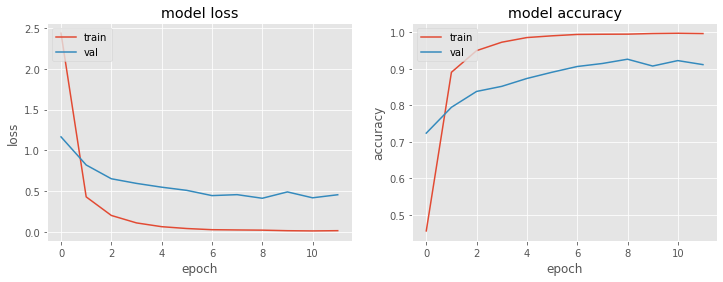

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results = []

In [ ]:
results.append(model1.evaluate(test_generator))
print(f"Final accuracy: {results[0][1]}")

89/89 [==============================] - 8s 87ms/step - loss: 0.4987 - categorical_accuracy: 0.9216
Final accuracy: 0.9216066002845764


###**32-32-64-128**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model1_2 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(32, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

model1_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_98 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_99 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model1_2.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model1_2.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 60s 112ms/step - loss: 3.7249 - categorical_accuracy: 0.2011 - val_loss: 1.1076 - val_categorical_accuracy: 0.7132
Epoch 2/50
529/529 [==============================] - 59s 112ms/step - loss: 0.5090 - categorical_accuracy: 0.8629 - val_loss: 0.8200 - val_categorical_accuracy: 0.7785
Epoch 3/50
529/529 [==============================] - 60s 113ms/step - loss: 0.2293 - categorical_accuracy: 0.9389 - val_loss: 0.6595 - val_categorical_accuracy: 0.8367
Epoch 4/50
529/529 [==============================] - 60s 113ms/step - loss: 0.1202 - categorical_accuracy: 0.9695 - val_loss: 0.5649 - val_categorical_accuracy: 0.8615
Epoch 5/50
529/529 [==============================] - 60s 114ms/step - loss: 0.0769 - categorical_accuracy: 0.9816 - val_loss: 0.5210 - val_categorical_accuracy: 0.8822
Epoch 6/50
529/529 [==============================] - 61s 114ms/step - loss: 0.0487 - categorical_accuracy: 0.9881 - val_loss: 0.4693 - val_categorical_acc

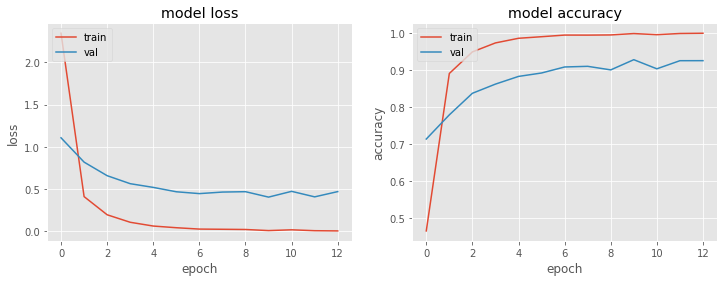

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model1_2.evaluate(test_generator))
print(f"Final accuracy: {results[1][1]}")

89/89 [==============================] - 8s 88ms/step - loss: 0.4551 - categorical_accuracy: 0.9191
Final accuracy: 0.919052243232727


###**32-64-64-128**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model1_3 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

model1_3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_103 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_104 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model1_3.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model1_3.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 64s 120ms/step - loss: 3.6701 - categorical_accuracy: 0.2114 - val_loss: 1.2093 - val_categorical_accuracy: 0.6969
Epoch 2/50
529/529 [==============================] - 64s 122ms/step - loss: 0.5324 - categorical_accuracy: 0.8576 - val_loss: 0.8158 - val_categorical_accuracy: 0.7841
Epoch 3/50
529/529 [==============================] - 65s 122ms/step - loss: 0.2231 - categorical_accuracy: 0.9391 - val_loss: 0.6303 - val_categorical_accuracy: 0.8359
Epoch 4/50
529/529 [==============================] - 65s 123ms/step - loss: 0.1088 - categorical_accuracy: 0.9726 - val_loss: 0.5115 - val_categorical_accuracy: 0.8773
Epoch 5/50
529/529 [==============================] - 65s 123ms/step - loss: 0.0547 - categorical_accuracy: 0.9874 - val_loss: 0.4930 - val_categorical_accuracy: 0.8828
Epoch 6/50
529/529 [==============================] - 65s 123ms/step - loss: 0.0401 - categorical_accuracy: 0.9901 - val_loss: 0.4746 - val_categorical_acc

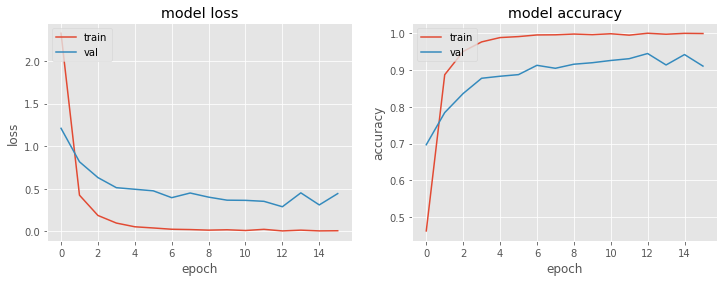

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model1_3.evaluate(test_generator))
print(f"Final accuracy: {results[2][1]}")

89/89 [==============================] - 8s 93ms/step - loss: 0.3477 - categorical_accuracy: 0.9389
Final accuracy: 0.9388707876205444


###**32-64-128-128**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model1_4 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(num_classes),
    Activation("softmax")
])

model1_4.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_108 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_109 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 20, 20, 128)     

In [ ]:
model1_4.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model1_4.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 67s 125ms/step - loss: 3.4497 - categorical_accuracy: 0.2562 - val_loss: 0.9610 - val_categorical_accuracy: 0.7481
Epoch 2/50
529/529 [==============================] - 66s 126ms/step - loss: 0.3712 - categorical_accuracy: 0.8990 - val_loss: 0.7057 - val_categorical_accuracy: 0.8245
Epoch 3/50
529/529 [==============================] - 66s 125ms/step - loss: 0.1426 - categorical_accuracy: 0.9638 - val_loss: 0.5183 - val_categorical_accuracy: 0.8651
Epoch 4/50
529/529 [==============================] - 66s 125ms/step - loss: 0.0711 - categorical_accuracy: 0.9815 - val_loss: 0.4752 - val_categorical_accuracy: 0.8954
Epoch 5/50
529/529 [==============================] - 66s 124ms/step - loss: 0.0343 - categorical_accuracy: 0.9923 - val_loss: 0.4706 - val_categorical_accuracy: 0.8982
Epoch 6/50
529/529 [==============================] - 65s 122ms/step - loss: 0.0330 - categorical_accuracy: 0.9916 - val_loss: 0.4333 - val_categorical_acc

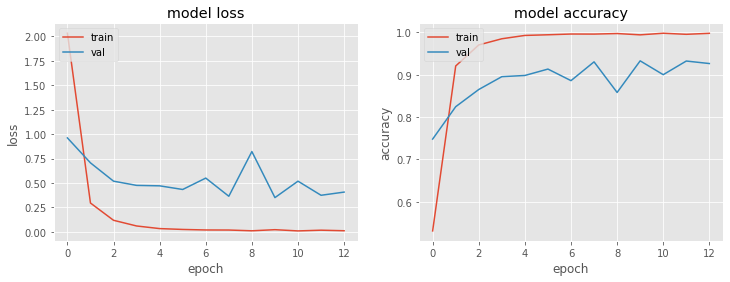

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model1_4.evaluate(test_generator))
print(f"Final accuracy: {results[3][1]}")

89/89 [==============================] - 8s 91ms/step - loss: 0.4095 - categorical_accuracy: 0.9242
Final accuracy: 0.9241610169410706


###**Save best model**

In [ ]:
results

[[0.49866044521331787, 0.9216066002845764],
 [0.4551341235637665, 0.919052243232727],
 [0.34765779972076416, 0.9388707876205444],
 [0.4095034599304199, 0.9241610169410706]]

In [ ]:
model1_3.save('drive/MyDrive/AML-Project/CNN_models/model_1')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_1/assets


## **Model 2: 1 Dense Layer, No Regularization**

####**256**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model2 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(256),
    Activation("relu"),
    Dense(num_classes),
    Activation("softmax")
])

model2.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_113 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_114 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model2.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model2.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 66s 123ms/step - loss: 3.7506 - categorical_accuracy: 0.2065 - val_loss: 1.1664 - val_categorical_accuracy: 0.7091
Epoch 2/50
529/529 [==============================] - 64s 122ms/step - loss: 0.4461 - categorical_accuracy: 0.8831 - val_loss: 0.6720 - val_categorical_accuracy: 0.8219
Epoch 3/50
529/529 [==============================] - 64s 122ms/step - loss: 0.1484 - categorical_accuracy: 0.9630 - val_loss: 0.4930 - val_categorical_accuracy: 0.8678
Epoch 4/50
529/529 [==============================] - 64s 122ms/step - loss: 0.0631 - categorical_accuracy: 0.9851 - val_loss: 0.4327 - val_categorical_accuracy: 0.8919
Epoch 5/50
529/529 [==============================] - 65s 122ms/step - loss: 0.0338 - categorical_accuracy: 0.9934 - val_loss: 0.4602 - val_categorical_accuracy: 0.8879
Epoch 6/50
529/529 [==============================] - 64s 122ms/step - loss: 0.0256 - categorical_accuracy: 0.9938 - val_loss: 0.3726 - val_categorical_acc

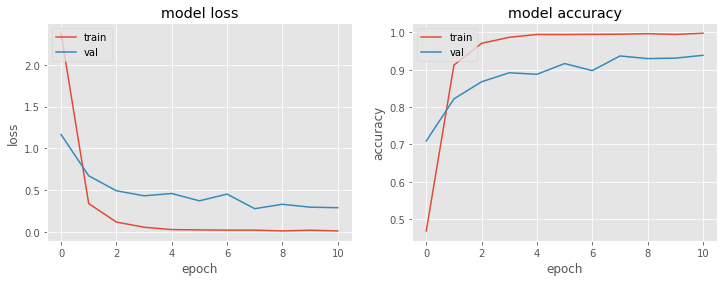

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results = [] 

In [ ]:
results.append(model2.evaluate(test_generator))
print(f"Final accuracy: {results[0][1]}")

89/89 [==============================] - 8s 90ms/step - loss: 0.3200 - categorical_accuracy: 0.9341
Final accuracy: 0.9341143369674683


####**512**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model2_2 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(512),
    Activation("relu"),
    Dense(num_classes),
    Activation("softmax")
])

model2_2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_119 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_120 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model2_2.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model2_2.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 64s 120ms/step - loss: 3.4988 - categorical_accuracy: 0.2539 - val_loss: 1.0830 - val_categorical_accuracy: 0.7287
Epoch 2/50
529/529 [==============================] - 63s 120ms/step - loss: 0.3611 - categorical_accuracy: 0.9013 - val_loss: 0.6549 - val_categorical_accuracy: 0.8367
Epoch 3/50
529/529 [==============================] - 64s 120ms/step - loss: 0.1168 - categorical_accuracy: 0.9700 - val_loss: 0.4978 - val_categorical_accuracy: 0.8872
Epoch 4/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0558 - categorical_accuracy: 0.9859 - val_loss: 0.4550 - val_categorical_accuracy: 0.9010
Epoch 5/50
529/529 [==============================] - 63s 120ms/step - loss: 0.0292 - categorical_accuracy: 0.9942 - val_loss: 0.4975 - val_categorical_accuracy: 0.8960
Epoch 6/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0534 - categorical_accuracy: 0.9864 - val_loss: 0.4219 - val_categorical_acc

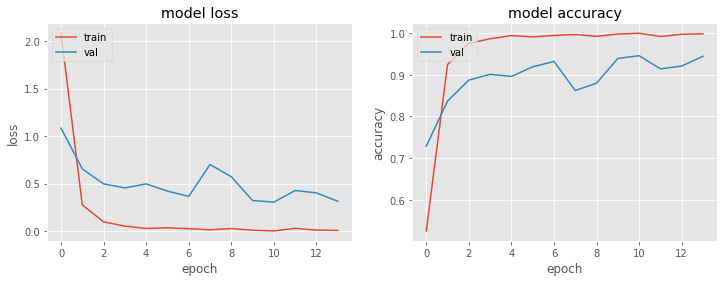

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model2_2.evaluate(test_generator))
print(f"Final accuracy: {results[1][1]}")

89/89 [==============================] - 8s 89ms/step - loss: 0.3781 - categorical_accuracy: 0.9375
Final accuracy: 0.9375495314598083


####**1024**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model2_3 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dense(num_classes),
    Activation("softmax")
])

model2_3.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_125 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_126 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model2_3.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model2_3.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 64s 120ms/step - loss: 3.1272 - categorical_accuracy: 0.3302 - val_loss: 0.9026 - val_categorical_accuracy: 0.7642
Epoch 2/50
529/529 [==============================] - 63s 119ms/step - loss: 0.2460 - categorical_accuracy: 0.9328 - val_loss: 0.5549 - val_categorical_accuracy: 0.8598
Epoch 3/50
529/529 [==============================] - 63s 119ms/step - loss: 0.0871 - categorical_accuracy: 0.9789 - val_loss: 0.4535 - val_categorical_accuracy: 0.8925
Epoch 4/50
529/529 [==============================] - 63s 119ms/step - loss: 0.0411 - categorical_accuracy: 0.9904 - val_loss: 0.4360 - val_categorical_accuracy: 0.9026
Epoch 5/50
529/529 [==============================] - 62s 118ms/step - loss: 0.0253 - categorical_accuracy: 0.9943 - val_loss: 0.4118 - val_categorical_accuracy: 0.9121
Epoch 6/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0256 - categorical_accuracy: 0.9937 - val_loss: 0.5313 - val_categorical_acc

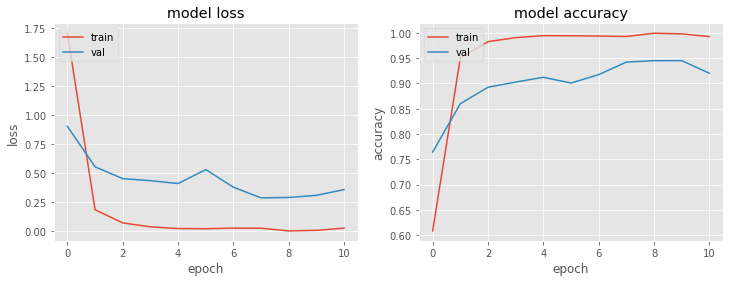

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model2_3.evaluate(test_generator))
print(f"Final accuracy: {results[2][1]}")

89/89 [==============================] - 8s 91ms/step - loss: 0.3310 - categorical_accuracy: 0.9381
Final accuracy: 0.9380780458450317


####**Save Best Model**

In [ ]:
results

[[0.31999289989471436, 0.9341143369674683],
 [0.37809914350509644, 0.9375495314598083],
 [0.3309905529022217, 0.9380780458450317]]

In [ ]:
model2_3.save('drive/MyDrive/AML-Project/CNN_models/model_3')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_3/assets


## **Model 3: 2 Dense Layers, No Regularization**

###**1024 + 256**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model3 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dense(256),
    Activation("relu"),
    Dense(num_classes),
    Activation("softmax")
])

model3.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_131 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_132 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
model3.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model3.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 66s 123ms/step - loss: 3.3056 - categorical_accuracy: 0.2949 - val_loss: 0.9596 - val_categorical_accuracy: 0.7432
Epoch 2/50
529/529 [==============================] - 65s 122ms/step - loss: 0.3049 - categorical_accuracy: 0.9201 - val_loss: 0.5600 - val_categorical_accuracy: 0.8558
Epoch 3/50
529/529 [==============================] - 65s 122ms/step - loss: 0.1004 - categorical_accuracy: 0.9733 - val_loss: 0.4459 - val_categorical_accuracy: 0.8829
Epoch 4/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0441 - categorical_accuracy: 0.9907 - val_loss: 0.3482 - val_categorical_accuracy: 0.9170
Epoch 5/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0361 - categorical_accuracy: 0.9909 - val_loss: 0.3312 - val_categorical_accuracy: 0.9182
Epoch 6/50
529/529 [==============================] - 63s 120ms/step - loss: 0.0242 - categorical_accuracy: 0.9948 - val_loss: 0.4691 - val_categorical_acc

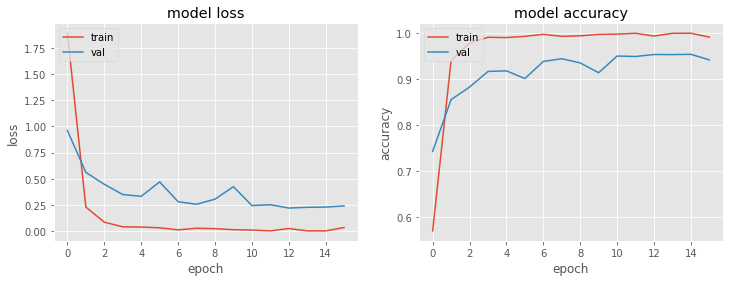

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results = [] 

In [ ]:
results.append(model3.evaluate(test_generator))
print(f"Final accuracy: {results[0][1]}")

89/89 [==============================] - 8s 92ms/step - loss: 0.2666 - categorical_accuracy: 0.9474
Final accuracy: 0.947414755821228


###**1024 + 512**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model3_2 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"), 
    Dense(512),
    Activation("relu"),
    Dense(num_classes),
    Activation("softmax")
])

model3_2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
activation_145 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_146 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 20, 20, 64)      

In [ ]:
model3_2.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model3_2.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 64s 120ms/step - loss: 3.1575 - categorical_accuracy: 0.3094 - val_loss: 1.1017 - val_categorical_accuracy: 0.7108
Epoch 2/50
529/529 [==============================] - 63s 118ms/step - loss: 0.3405 - categorical_accuracy: 0.9024 - val_loss: 0.6510 - val_categorical_accuracy: 0.8239
Epoch 3/50
529/529 [==============================] - 63s 118ms/step - loss: 0.1182 - categorical_accuracy: 0.9676 - val_loss: 0.5293 - val_categorical_accuracy: 0.8754
Epoch 4/50
529/529 [==============================] - 63s 118ms/step - loss: 0.0520 - categorical_accuracy: 0.9872 - val_loss: 0.4886 - val_categorical_accuracy: 0.8934
Epoch 5/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0262 - categorical_accuracy: 0.9939 - val_loss: 0.6851 - val_categorical_accuracy: 0.8693
Epoch 6/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0493 - categorical_accuracy: 0.9869 - val_loss: 0.4393 - val_categorical_acc

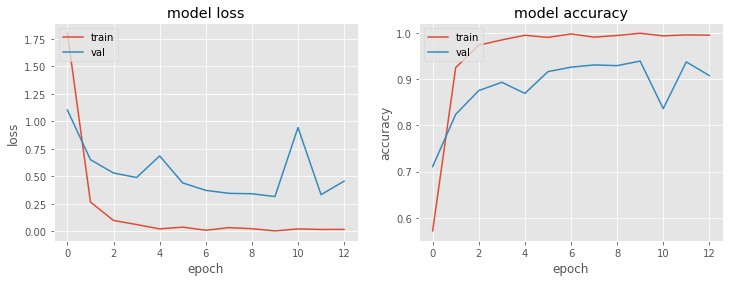

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model3_2.evaluate(test_generator))
print(f"Final accuracy: {results[1][1]}")

89/89 [==============================] - 8s 93ms/step - loss: 0.3529 - categorical_accuracy: 0.9362
Final accuracy: 0.936228334903717


###**1024 + 1024**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model3_3 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dense(1024),
    Activation("relu"),
    Dense(num_classes),
    Activation("softmax")
])

model3_3.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 98, 98, 32)        896       
_________________________________________________________________
activation_159 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_160 (Activation)  (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 20, 20, 64)      

In [ ]:
model3_3.compile(optimizer = optimizers.Adam(0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model3_3.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 65s 122ms/step - loss: 3.1281 - categorical_accuracy: 0.3197 - val_loss: 0.7457 - val_categorical_accuracy: 0.7941
Epoch 2/50
529/529 [==============================] - 64s 122ms/step - loss: 0.2289 - categorical_accuracy: 0.9393 - val_loss: 0.4434 - val_categorical_accuracy: 0.8837
Epoch 3/50
529/529 [==============================] - 64s 120ms/step - loss: 0.0725 - categorical_accuracy: 0.9828 - val_loss: 0.3400 - val_categorical_accuracy: 0.9208
Epoch 4/50
529/529 [==============================] - 64s 121ms/step - loss: 0.0454 - categorical_accuracy: 0.9889 - val_loss: 0.2832 - val_categorical_accuracy: 0.9364
Epoch 5/50
529/529 [==============================] - 64s 121ms/step - loss: 0.0201 - categorical_accuracy: 0.9947 - val_loss: 0.3450 - val_categorical_accuracy: 0.9259
Epoch 6/50
529/529 [==============================] - 64s 121ms/step - loss: 0.0214 - categorical_accuracy: 0.9946 - val_loss: 0.2340 - val_categorical_acc

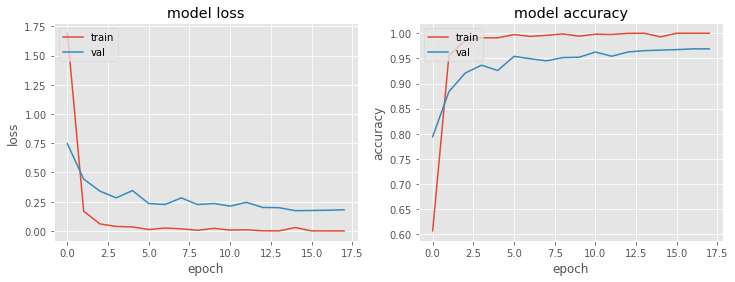

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model3_3.evaluate(test_generator))
print(f"Final accuracy: {results[2][1]}")

89/89 [==============================] - 8s 92ms/step - loss: 0.2170 - categorical_accuracy: 0.9615
Final accuracy: 0.9615079760551453


###**Save Best Model**

In [ ]:
results

[[0.2666490972042084, 0.947414755821228],
 [0.352866530418396, 0.936228334903717],
 [0.21697326004505157, 0.9615079760551453]]

In [ ]:
model3_3.save('drive/MyDrive/AML-Project/CNN_models/model_3')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_3/assets


## **Model 4: 2 Dense Layers, With Dropout**

###**0.2**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model4 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dropout(0.2),
    Dense(1024),
    Activation("relu"),
    Dropout(0.2),
    Dense(num_classes),
    Activation("softmax")
])

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        6

In [ ]:
model4.compile(optimizer= optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model4.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 85s 98ms/step - loss: 3.4536 - categorical_accuracy: 0.2252 - val_loss: 0.7840 - val_categorical_accuracy: 0.7980
Epoch 2/50
529/529 [==============================] - 50s 95ms/step - loss: 0.5328 - categorical_accuracy: 0.8367 - val_loss: 0.4185 - val_categorical_accuracy: 0.8910
Epoch 3/50
529/529 [==============================] - 51s 96ms/step - loss: 0.1931 - categorical_accuracy: 0.9411 - val_loss: 0.3420 - val_categorical_accuracy: 0.9093
Epoch 4/50
529/529 [==============================] - 51s 96ms/step - loss: 0.0966 - categorical_accuracy: 0.9710 - val_loss: 0.2504 - val_categorical_accuracy: 0.9404
Epoch 5/50
529/529 [==============================] - 50s 95ms/step - loss: 0.0570 - categorical_accuracy: 0.9825 - val_loss: 0.2460 - val_categorical_accuracy: 0.9427
Epoch 6/50
529/529 [==============================] - 50s 95ms/step - loss: 0.0372 - categorical_accuracy: 0.9889 - val_loss: 0.2240 - val_categorical_accuracy:

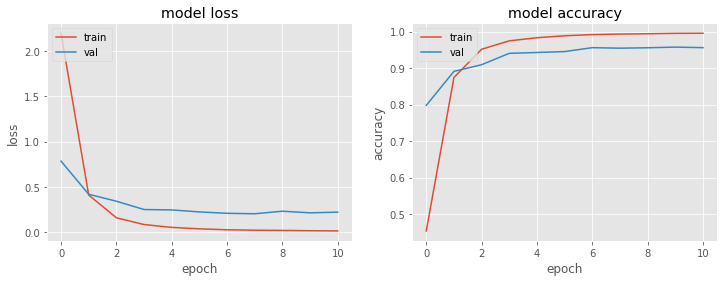

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results = []

In [ ]:
results.append(model4.evaluate(test_generator))
print(f"Final accuracy: {results[0][1]}")

89/89 [==============================] - 7s 77ms/step - loss: 0.2334 - categorical_accuracy: 0.9504
Final accuracy: 0.9504095911979675


###**0.3**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model4_2 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dropout(0.3),
    Dense(1024),
    Activation("relu"),
    Dropout(0.3),
    Dense(num_classes),
    Activation("softmax")
])

model4_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_8 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)       

In [ ]:
model4_2.compile(optimizer= optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model4_2.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 51s 96ms/step - loss: 3.8579 - categorical_accuracy: 0.1495 - val_loss: 0.9383 - val_categorical_accuracy: 0.7629
Epoch 2/50
529/529 [==============================] - 50s 95ms/step - loss: 0.8066 - categorical_accuracy: 0.7548 - val_loss: 0.4697 - val_categorical_accuracy: 0.8745
Epoch 3/50
529/529 [==============================] - 50s 95ms/step - loss: 0.3119 - categorical_accuracy: 0.9038 - val_loss: 0.3329 - val_categorical_accuracy: 0.9134
Epoch 4/50
529/529 [==============================] - 50s 95ms/step - loss: 0.1651 - categorical_accuracy: 0.9472 - val_loss: 0.2901 - val_categorical_accuracy: 0.9240
Epoch 5/50
529/529 [==============================] - 50s 95ms/step - loss: 0.1042 - categorical_accuracy: 0.9675 - val_loss: 0.2414 - val_categorical_accuracy: 0.9413
Epoch 6/50
529/529 [==============================] - 50s 94ms/step - loss: 0.0687 - categorical_accuracy: 0.9784 - val_loss: 0.2128 - val_categorical_accuracy:

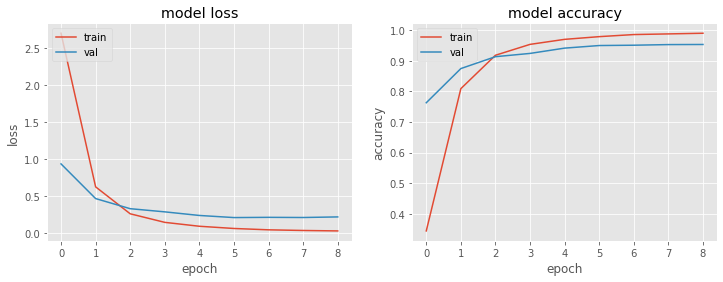

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model4_2.evaluate(test_generator))
print(f"Final accuracy: {results[1][1]}")

89/89 [==============================] - 6s 72ms/step - loss: 0.2485 - categorical_accuracy: 0.9417
Final accuracy: 0.9416894316673279


###**0.4**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234)

model4_3 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dropout(0.4),
    Dense(1024),
    Activation("relu"),
    Dropout(0.4),
    Dense(num_classes),
    Activation("softmax")
])

model4_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_15 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
model4_3.compile(optimizer= optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model4_3.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 51s 95ms/step - loss: 4.0297 - categorical_accuracy: 0.1205 - val_loss: 1.0533 - val_categorical_accuracy: 0.7559
Epoch 2/50
529/529 [==============================] - 49s 93ms/step - loss: 1.0704 - categorical_accuracy: 0.6806 - val_loss: 0.5417 - val_categorical_accuracy: 0.8491
Epoch 3/50
529/529 [==============================] - 49s 93ms/step - loss: 0.4609 - categorical_accuracy: 0.8587 - val_loss: 0.3498 - val_categorical_accuracy: 0.9070
Epoch 4/50
529/529 [==============================] - 50s 94ms/step - loss: 0.2529 - categorical_accuracy: 0.9202 - val_loss: 0.2909 - val_categorical_accuracy: 0.9223
Epoch 5/50
529/529 [==============================] - 50s 94ms/step - loss: 0.1570 - categorical_accuracy: 0.9505 - val_loss: 0.2380 - val_categorical_accuracy: 0.9391
Epoch 6/50
529/529 [==============================] - 50s 94ms/step - loss: 0.1069 - categorical_accuracy: 0.9661 - val_loss: 0.2226 - val_categorical_accuracy:

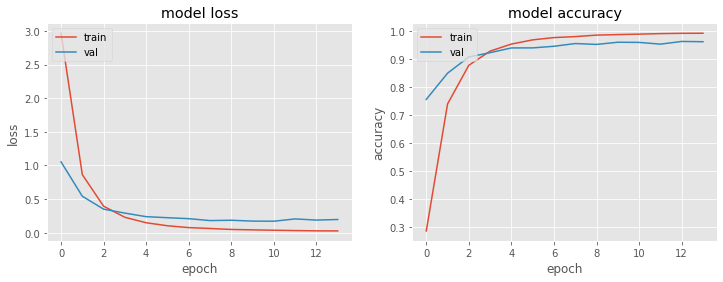

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model4_3.evaluate(test_generator))
print(f"Final accuracy: {results[2][1]}")

89/89 [==============================] - 6s 71ms/step - loss: 0.1945 - categorical_accuracy: 0.9537
Final accuracy: 0.9536686539649963


###**0.5**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model4_4 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024),
    Activation("relu"),
    Dropout(0.5),
    Dense(1024),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax")
])

model4_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_28 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_29 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
model4_4.compile(optimizer = optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model4_4.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 50s 93ms/step - loss: 4.2923 - categorical_accuracy: 0.0740 - val_loss: 1.4825 - val_categorical_accuracy: 0.6828
Epoch 2/50
529/529 [==============================] - 49s 93ms/step - loss: 1.5700 - categorical_accuracy: 0.5433 - val_loss: 0.6740 - val_categorical_accuracy: 0.8236
Epoch 3/50
529/529 [==============================] - 49s 93ms/step - loss: 0.7361 - categorical_accuracy: 0.7752 - val_loss: 0.4595 - val_categorical_accuracy: 0.8694
Epoch 4/50
529/529 [==============================] - 49s 93ms/step - loss: 0.4326 - categorical_accuracy: 0.8633 - val_loss: 0.3634 - val_categorical_accuracy: 0.9005
Epoch 5/50
529/529 [==============================] - 49s 93ms/step - loss: 0.2886 - categorical_accuracy: 0.9065 - val_loss: 0.2938 - val_categorical_accuracy: 0.9229
Epoch 6/50
529/529 [==============================] - 49s 93ms/step - loss: 0.2041 - categorical_accuracy: 0.9352 - val_loss: 0.2448 - val_categorical_accuracy:

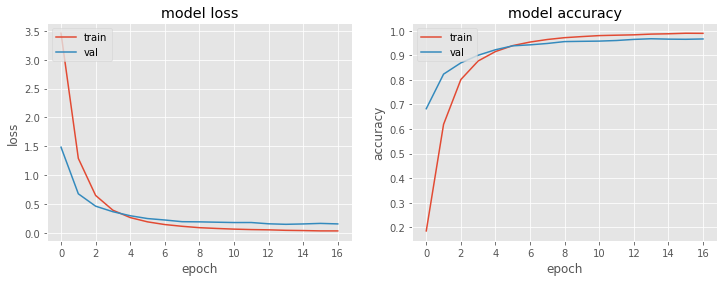

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model4_4.evaluate(test_generator))
print(f"Final accuracy: {results[3][1]}")

89/89 [==============================] - 6s 72ms/step - loss: 0.1691 - categorical_accuracy: 0.9619
Final accuracy: 0.9618602991104126


###**Save Best Model**

In [ ]:
results

[[0.2333603799343109, 0.9504095911979675],
 [0.2484935075044632, 0.9416894316673279],
 [0.19447417557239532, 0.9536686539649963],
 [0.1691272258758545, 0.9618602991104126]]

In [ ]:
model4_4.save('drive/MyDrive/AML-Project/CNN_models/model_4')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_4/assets


##**Model 5: 2 Dense Layer, With Dropout and L2 Regularization**

###**0.005**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model5 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    Activation("relu"),
    Dropout(0.5),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax")
])

model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_35 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_36 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
model5.compile(optimizer= optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model5.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 51s 94ms/step - loss: 13.3911 - categorical_accuracy: 0.0575 - val_loss: 6.5054 - val_categorical_accuracy: 0.6679
Epoch 2/50
529/529 [==============================] - 49s 93ms/step - loss: 6.2330 - categorical_accuracy: 0.5504 - val_loss: 4.6261 - val_categorical_accuracy: 0.8318
Epoch 3/50
529/529 [==============================] - 50s 94ms/step - loss: 4.5123 - categorical_accuracy: 0.7906 - val_loss: 3.8809 - val_categorical_accuracy: 0.8824
Epoch 4/50
529/529 [==============================] - 49s 93ms/step - loss: 3.7010 - categorical_accuracy: 0.8778 - val_loss: 3.3157 - val_categorical_accuracy: 0.9126
Epoch 5/50
529/529 [==============================] - 49s 93ms/step - loss: 3.1251 - categorical_accuracy: 0.9260 - val_loss: 2.8473 - val_categorical_accuracy: 0.9293
Epoch 6/50
529/529 [==============================] - 50s 94ms/step - loss: 2.6687 - categorical_accuracy: 0.9468 - val_loss: 2.4612 - val_categorical_accuracy

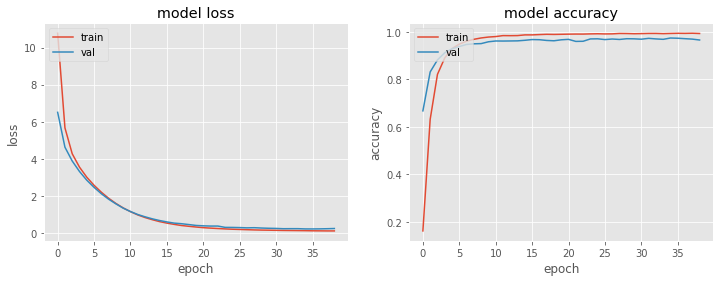

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results = []

In [ ]:
results.append(model5.evaluate(test_generator))
print(f"Final accuracy: {results[0][1]}")

89/89 [==============================] - 8s 89ms/step - loss: 0.2550 - categorical_accuracy: 0.9693
Final accuracy: 0.9693472981452942


###**0.01**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model5_2 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    Activation("relu"),
    Dropout(0.5),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax")
])

model5_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_42 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_43 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
model5_2.compile(optimizer= optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model5_2.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 51s 96ms/step - loss: 21.6457 - categorical_accuracy: 0.0499 - val_loss: 9.2173 - val_categorical_accuracy: 0.6250
Epoch 2/50
529/529 [==============================] - 49s 93ms/step - loss: 8.3882 - categorical_accuracy: 0.5200 - val_loss: 5.7730 - val_categorical_accuracy: 0.8222
Epoch 3/50
529/529 [==============================] - 49s 93ms/step - loss: 5.4489 - categorical_accuracy: 0.7937 - val_loss: 4.4495 - val_categorical_accuracy: 0.8666
Epoch 4/50
529/529 [==============================] - 49s 93ms/step - loss: 4.1559 - categorical_accuracy: 0.8818 - val_loss: 3.5542 - val_categorical_accuracy: 0.9062
Epoch 5/50
529/529 [==============================] - 50s 94ms/step - loss: 3.2808 - categorical_accuracy: 0.9274 - val_loss: 2.8615 - val_categorical_accuracy: 0.9343
Epoch 6/50
529/529 [==============================] - 50s 94ms/step - loss: 2.6230 - categorical_accuracy: 0.9479 - val_loss: 2.3371 - val_categorical_accuracy

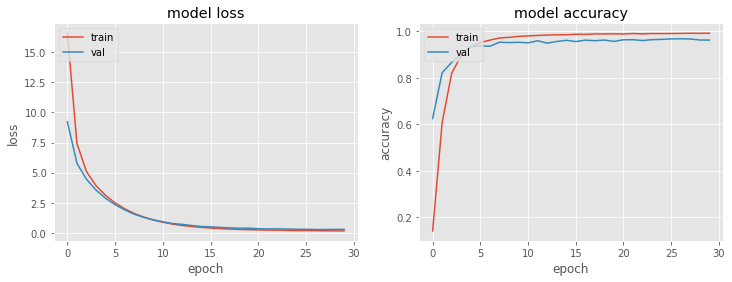

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model5_2.evaluate(test_generator))
print(f"Final accuracy: {results[1][1]}")

89/89 [==============================] - 7s 73ms/step - loss: 0.3082 - categorical_accuracy: 0.9614
Final accuracy: 0.9614198803901672


###**0.02**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234)

model5_3 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.02)),
    Activation("relu"),
    Dropout(0.5),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.02)),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax")
])

model5_3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_56 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_57 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
model5_3.compile(optimizer= optimizers.Adam(lr = 0.00005),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3, restore_best_weights = True)

In [ ]:
%%time

hist = model5_3.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 51s 95ms/step - loss: 38.4066 - categorical_accuracy: 0.0423 - val_loss: 14.1093 - val_categorical_accuracy: 0.6064
Epoch 2/50
529/529 [==============================] - 50s 94ms/step - loss: 12.1283 - categorical_accuracy: 0.4971 - val_loss: 7.4132 - val_categorical_accuracy: 0.7924
Epoch 3/50
529/529 [==============================] - 50s 94ms/step - loss: 6.7322 - categorical_accuracy: 0.7700 - val_loss: 4.9923 - val_categorical_accuracy: 0.8682
Epoch 4/50
529/529 [==============================] - 50s 94ms/step - loss: 4.5345 - categorical_accuracy: 0.8717 - val_loss: 3.6217 - val_categorical_accuracy: 0.8847
Epoch 5/50
529/529 [==============================] - 49s 93ms/step - loss: 3.2497 - categorical_accuracy: 0.9151 - val_loss: 2.6967 - val_categorical_accuracy: 0.9015
Epoch 6/50
529/529 [==============================] - 50s 94ms/step - loss: 2.3777 - categorical_accuracy: 0.9394 - val_loss: 2.0295 - val_categorical_accura

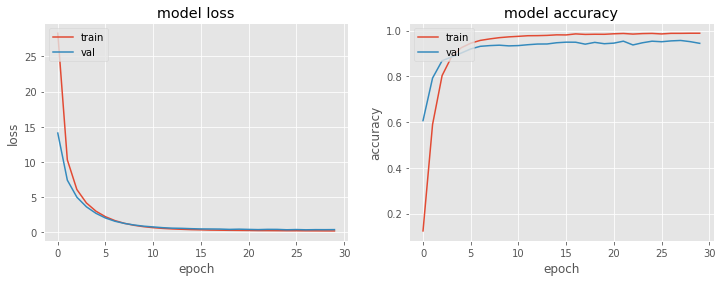

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results.append(model5_3.evaluate(test_generator))
print(f"Final accuracy: {results[2][1]}")

89/89 [==============================] - 10s 111ms/step - loss: 0.3776 - categorical_accuracy: 0.9482
Final accuracy: 0.9482074975967407


###**Save Best Model**

In [ ]:
results

[[0.2549927830696106, 0.9693472981452942],
 [0.30819612741470337, 0.9614198803901672],
 [0.3776191174983978, 0.9482074975967407]]

In [ ]:
model5.save('drive/MyDrive/AML-Project/CNN_models/model_5')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_5/assets


##**Model 6: Increasing Early Stopping Patience**


In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234)

model6 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    Activation("relu"),
    Dropout(0.5),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax")
])

model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_15 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
model6.compile(optimizer = optimizers.Adam(lr = 0.0001),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5, restore_best_weights = True)

In [ ]:
%%time

hist = model6.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks = [es])

Epoch 1/50
529/529 [==============================] - 64s 119ms/step - loss: 11.2141 - categorical_accuracy: 0.1410 - val_loss: 4.0251 - val_categorical_accuracy: 0.8131
Epoch 2/50
529/529 [==============================] - 63s 118ms/step - loss: 3.7233 - categorical_accuracy: 0.7926 - val_loss: 2.7510 - val_categorical_accuracy: 0.9059
Epoch 3/50
529/529 [==============================] - 63s 119ms/step - loss: 2.4866 - categorical_accuracy: 0.9223 - val_loss: 2.0708 - val_categorical_accuracy: 0.9243
Epoch 4/50
529/529 [==============================] - 62s 117ms/step - loss: 1.8005 - categorical_accuracy: 0.9551 - val_loss: 1.5270 - val_categorical_accuracy: 0.9437
Epoch 5/50
529/529 [==============================] - 62s 118ms/step - loss: 1.3304 - categorical_accuracy: 0.9666 - val_loss: 1.1620 - val_categorical_accuracy: 0.9515
Epoch 6/50
529/529 [==============================] - 62s 118ms/step - loss: 0.9899 - categorical_accuracy: 0.9752 - val_loss: 0.9159 - val_categorical_ac

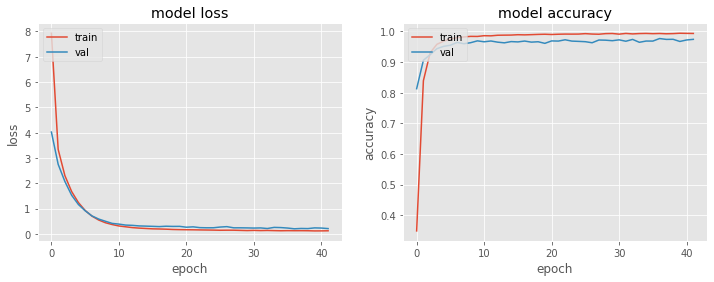

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
result = model6.evaluate(test_generator)
print(f"Final accuracy: {result}")

89/89 [==============================] - 8s 85ms/step - loss: 0.2133 - categorical_accuracy: 0.9745
Final accuracy: [0.21329252421855927, 0.9744560718536377]


In [ ]:
model6.save('drive/MyDrive/AML-Project/CNN_models/model_6')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_6/assets


## **Model 7: Adding Data Augmentation**

In [ ]:
num_classes = len(np.unique(train_generator.labels))


# inserisci
# - L'inizializzazione
# - Regolarizzazione

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 

model7 = Sequential(
[
    Input(shape = (H,W,3)),
    Conv2D(32, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(64, (4,4)),
    Activation("relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3)),
    Activation("relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    Activation("relu"),
    Dropout(0.5),
    Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(0.005)),
    Activation("relu"),
    Dropout(0.5),
    Dense(num_classes),
    Activation("softmax")
])

model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        6

In [ ]:
model7.compile(optimizer= optimizers.Adam(lr = 0.0001),
              loss = categorical_crossentropy,
              metrics = categorical_accuracy)

In [ ]:
%%time

hist = model7.fit(train_generator_augmented,
          validation_data = val_generator,
          epochs = 25,
          )

Epoch 1/25
529/529 [==============================] - 211s 341ms/step - loss: 11.3957 - categorical_accuracy: 0.0441 - val_loss: 4.3479 - val_categorical_accuracy: 0.3354
Epoch 2/25
529/529 [==============================] - 180s 339ms/step - loss: 3.9248 - categorical_accuracy: 0.3470 - val_loss: 2.6176 - val_categorical_accuracy: 0.6433
Epoch 3/25
529/529 [==============================] - 182s 343ms/step - loss: 2.5760 - categorical_accuracy: 0.5648 - val_loss: 1.9880 - val_categorical_accuracy: 0.7007
Epoch 4/25
529/529 [==============================] - 178s 336ms/step - loss: 1.9418 - categorical_accuracy: 0.6767 - val_loss: 1.6484 - val_categorical_accuracy: 0.7382
Epoch 5/25
529/529 [==============================] - 177s 335ms/step - loss: 1.5507 - categorical_accuracy: 0.7465 - val_loss: 1.3567 - val_categorical_accuracy: 0.7937
Epoch 6/25
529/529 [==============================] - 178s 336ms/step - loss: 1.2769 - categorical_accuracy: 0.7893 - val_loss: 1.1436 - val_categori

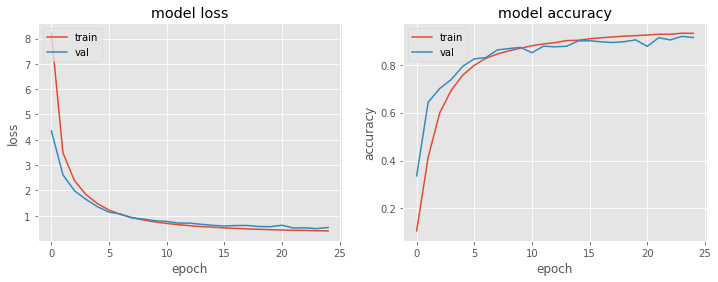

In [ ]:
plt.style.use("ggplot")

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(hist.history['categorical_accuracy'])
ax2.plot(hist.history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
result = model7.evaluate(test_generator)
print(f"Final accuracy: {result[1]}")

89/89 [==============================] - 7s 82ms/step - loss: 0.5931 - categorical_accuracy: 0.9023
Final accuracy: 0.9023165702819824


In [ ]:
model7.save('drive/MyDrive/AML-Project/CNN_models/model_7')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/CNN_models/model_7/assets
